In [ ]:
!cp drive/My\ Drive/time-series-analysis/london_bike_sharing_dataset.csv .

### Importing libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
import seaborn as sns
from matplotlib import rc
from pylab import rcParams

rcParams['figure.figsize'] = 22, 6

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load data

In [ ]:
df = pd.read_csv('london_bike_sharing_dataset.csv',parse_dates=['timestamp'],index_col='timestamp')
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


#### Get a copy of the data

In [ ]:
df_copy = df.copy()

## Exploratory data analysis

### Extracting extra features from timestamps

In [ ]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6,4,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,4,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6,4,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6,4,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,6,4,1


### total numbers of bike shared during the period

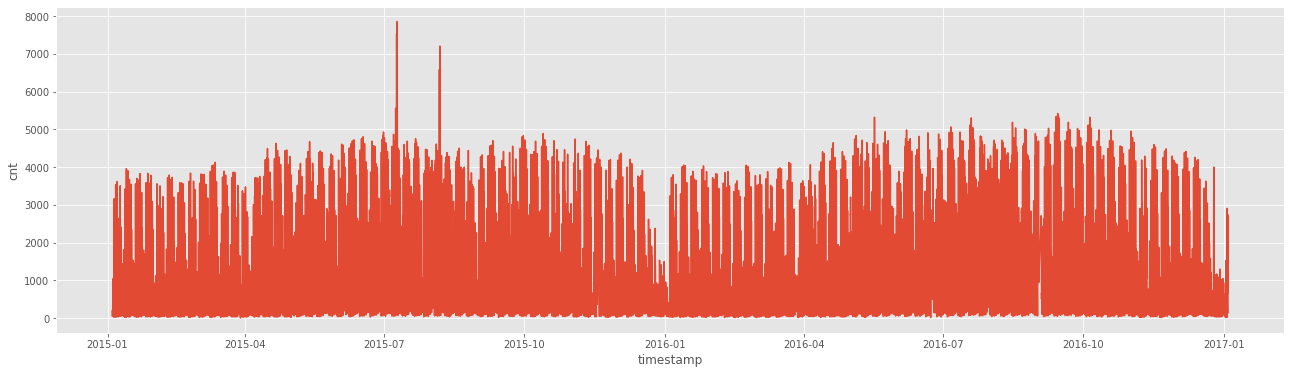

In [ ]:
sns.lineplot(x=df.index, y=df.cnt);

### total numbers of bike shared during each month 

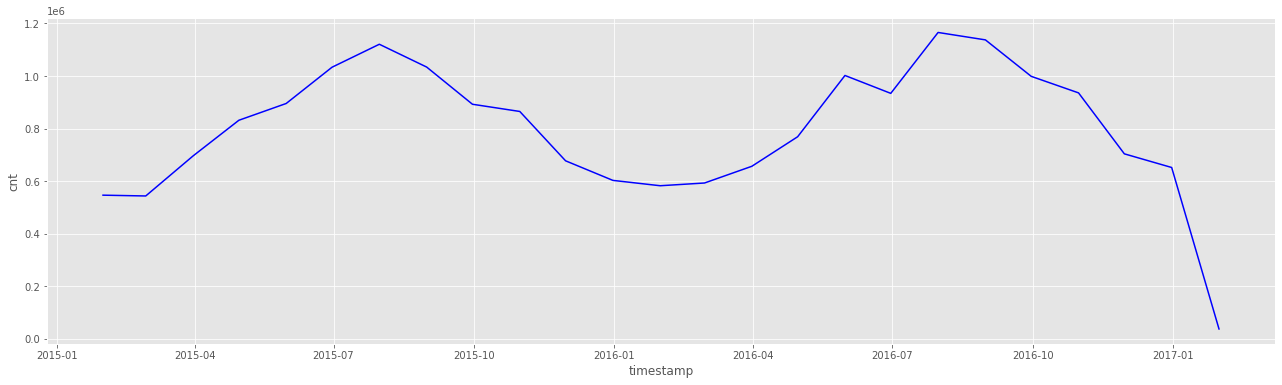

In [ ]:
df_by_month = df.resample('M').sum()
sns.lineplot(x=df_by_month.index, y='cnt', data=df_by_month, color='b');

### total numbers of bike shared in each hour in comparison with holidays

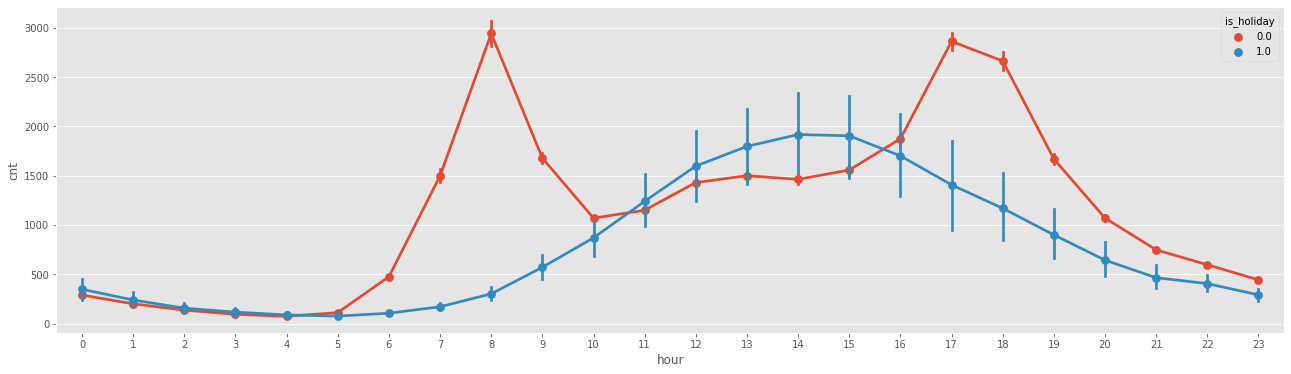

In [ ]:
sns.pointplot(x='hour',y='cnt', data=df, hue='is_holiday');

### total numbers of bike shared during each day of the week

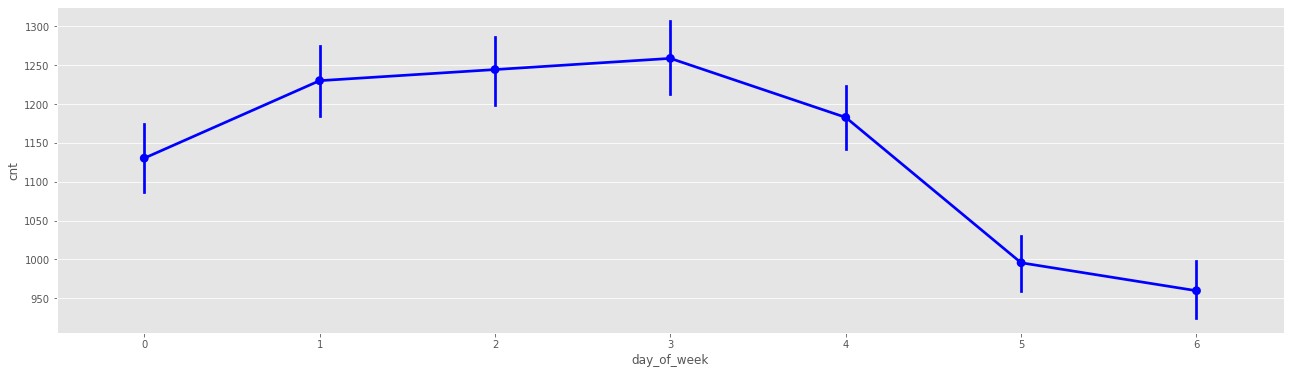

In [ ]:
sns.pointplot(x='day_of_week',y='cnt', data=df, color='b');

## Splitting train & test

In [ ]:
train_size = int(len(df_)*0.9)
test_size = len(df) - train_size
train , test = df.iloc[:train_size], df.iloc[train_size:]
print(train.shape, test.shape)

(15672, 9) (1742, 9)


## Feature scaling

In [ ]:
from sklearn.preprocessing import RobustScaler
pd.options.mode.chained_assignment = None

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

### Converting the data to a time series format

In [ ]:
def to_sequence(X, y, time_steps=1):
  Xs, ys = [], []
  for i in range(len(X) - time_steps):
    v = X.iloc[i: (i + time_steps)].to_numpy()
    Xs.append(v)
    ys.append(y.iloc[i + time_steps])
  return np.asarray(Xs), np.asarray(ys)

TIMESTEPS = 24

x_train, y_train = to_sequence(train, train['cnt'], TIMESTEPS)
x_test, y_test = to_sequence(test, test['cnt'], TIMESTEPS)
print(f"X_train shape is {x_train.shape}, and y_train shape is {y_train.shape}")

X_train shape is (15648, 24, 13), and y_train shape is (15648,)


## Defining a model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Bidirectional, Dense
model = Sequential()
model.add(Bidirectional(LSTM(units=128),input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate=0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 256)               145408    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 145,665
Trainable params: 145,665
Non-trainable params: 0
_________________________________________________________________


### Fitting the model on data

In [ ]:
history = model.fit(x_train, y_train, batch_size=16, validation_split=0.1, epochs=100, shuffle=False)

Epoch 1/100
881/881 [==============================] - 15s 17ms/step - loss: 0.2222 - acc: 6.3907e-04 - val_loss: 0.1067 - val_acc: 6.3898e-04
Epoch 2/100
881/881 [==============================] - 13s 15ms/step - loss: 0.0707 - acc: 9.2310e-04 - val_loss: 0.0567 - val_acc: 6.3898e-04
Epoch 3/100
881/881 [==============================] - 14s 16ms/step - loss: 0.0486 - acc: 9.2310e-04 - val_loss: 0.0519 - val_acc: 6.3898e-04
Epoch 4/100
881/881 [==============================] - 14s 15ms/step - loss: 0.0389 - acc: 9.2310e-04 - val_loss: 0.0503 - val_acc: 6.3898e-04
Epoch 5/100
881/881 [==============================] - 14s 15ms/step - loss: 0.0347 - acc: 9.2310e-04 - val_loss: 0.0385 - val_acc: 6.3898e-04
Epoch 6/100
881/881 [==============================] - 13s 15ms/step - loss: 0.0295 - acc: 9.2310e-04 - val_loss: 0.0317 - val_acc: 6.3898e-04
Epoch 7/100
881/881 [==============================] - 14s 15ms/step - loss: 0.0279 - acc: 9.2310e-04 - val_loss: 0.0290 - val_acc: 6.3898e-04

### Model loss visualization

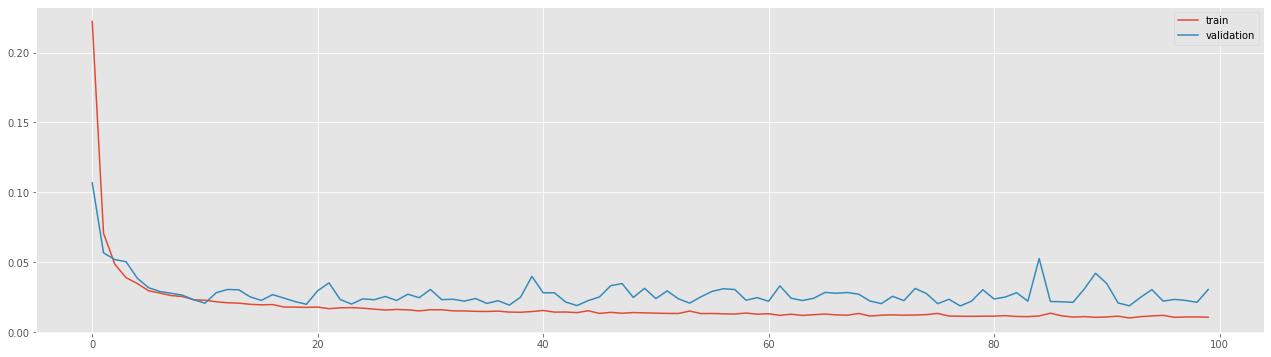

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

### Model prediction

In [ ]:
y_pred = model.predict(x_test)

y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1,-1))
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1,-1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

### Model prediction visualization

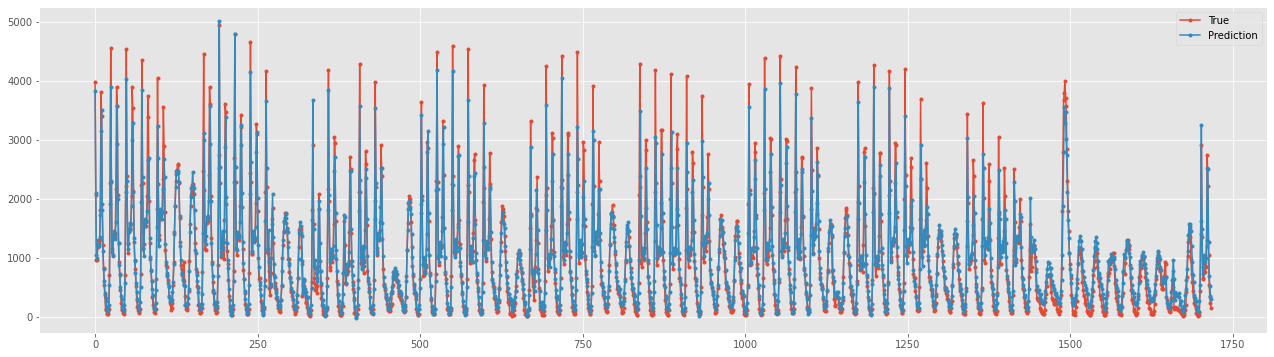

In [ ]:
plt.plot(y_test_inv.flatten(), marker='.', label='True')
plt.plot(y_pred_inv, marker='.', label='Prediction')
plt.legend();